In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib 
import os
from scipy import signal

import torch
import time
import pdb

import PT_files.save_load as sl
from DnCNN_NP.layers  import relu#, np_BatchNorm2d, np_Conv2d

In [2]:
PATH = pathlib.Path(os.getenv('PSCRATCH'))
DATA = PATH / 'DESI_dn' /'Model_params'
assert DATA.exists()
name = '6k_model_wb_e800_lys20_58feat.pth'

# weights = np.load(DATA / name)
weights = torch.load(str(DATA / name))


#Load the actual data that we're working on & print the shape of this data
test_data = sl.NERSC_load('test_data_40%_6000.npy')
sample = test_data[0]
print('Shape of test set=', sample.shape)

Shape of test set= (108, 1, 6000, 6000)


Want to see if writing my own convolve2d will be faster!

In [3]:
def np_Conv2d(input_data, weights_dict, prefix, stride=1, padding="same", dilation=1):
    """
    Numpy implementation of the PyTorch Conv2d layer that uses the 
    learned PyTorch weights in the model.
    
    Parameters:
    -----------
    input_data: nd.array
        Input data of shape '(batch_size, in_channels, height, width)'
    weights_dict: OrderedDict
        weights_dict['weight']: torch.Tensor
            Weights tensor of shape '(out_channels, in_channels, kernel_size[0], kernel_size[1])'
        weights_dict['bias']: torch.Tensor
            Bias tensor of shape '(out_channels)'
    stride: int, optional
        The number of entries by which the filter is moved at each step.
        Defaults to 1
    padding: str, optional
        What padding strategy to use for this conv layer. Defaults to "same",
        which pads the layer such that the output has the same height and width
        as the input when the stride = 1. Specifically makes output of
        scipy.correlate2d have same shape as in1. An alternative option is "valid",
        which means no padding is done and the output has smaller dimensions
        than the input.
    dilation: int, optional
        Spacing between kernel elements.
        Defaults to 1.
     
        
    Returns:
    --------
    output: nd.array
        Array output of the convolution step with shape
        `(batch_size, out_channels, out_height, out_width)`.
    
    """
    
    # Checking to see if a single sample or a batch of samples is given.
    # If batch take the batch_size, in_channels, H, and W
    # If single sample is given reshape so the values above can be calculated
    dimensions_start = time.perf_counter()
    if len(input_data.shape) == 4:
    
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    elif len(input_data.shape) == 3:
        
        input_data = input_data.reshape((1, 1, 6000 , 6000))
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    dimensions_end = time.perf_counter()
    print('Getting input dimensions takes', dimensions_end-dimensions_start, 'seconds')

    # Load the weights and biases needed for a convolution
    # then take off gpu memory, move to CPU memory,
    # and lastly transform to numpy
    loading_start = time.perf_counter()
    weight = weights_dict[str(prefix) + 'weight']
    weight = weight.detach().cpu().numpy()
    bias = weights_dict[str(prefix) + 'bias']
    bias = bias.detach().cpu().numpy()
    
    # Calculate the kernel size and output channels from
    # the loaded weights from above
    kernel_size = weight[0][0].shape
    output_channels = len(weight)
    loading_end = time.perf_counter()
    print('Loading the weights takes', loading_end-loading_start, 'seconds')
    
    # Convert string padding into numerical padding
    # Using strings allow for one variable to account for padding & mode (see signal.correlated2d)
    out_dimensions_start = time.perf_counter()
    mode = padding
    if mode == "same":
        padding = 1
    elif mode == "valid":
        padding = 0
    
    # Calculations for the output H and W dimensions
    height_out = ((height + (2*padding) - dilation * (kernel_size[0] - 1) - 1) / stride) + 1
    height_out = int(height_out)
    width_out = ((width + (2*padding) - dilation * (kernel_size[1] - 1) - 1) / stride) + 1
    width_out = int(width_out)

    # Create empty array of correct output dimensions
    output = np.empty((batch_size, output_channels, height_out, width_out))
    out_dimensions_end = time.perf_counter()
    print('Getting output dimensions takes', out_dimensions_end-out_dimensions_start, 'seconds')
    
    # Place the cross correlated elements into the newly created 
    # empty array of correct output dimensions
    loop_start = time.perf_counter()
    
    for j in range(output_channels):
        for i in range(batch_size):
            for k in range(input_channels):
                # See PyTorch docs for this eqn: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
                output[i, j, :, :] = bias[j] + signal.correlate2d(input_data[i][k], weight[j][k], mode=mode)
    loop_end = time.perf_counter()
    print('Convolution loop takes', loop_end-loop_start, 'seconds')
    
    return output


def np_BatchNorm2d(input_data, prefix, weights_dict, epsilon=1e-5):
    
    x = input_data
    
    gamma = weights_dict[str(prefix) + 'weight'].detach().cpu().numpy().reshape(-1, 1, 1)
    beta = weights_dict[str(prefix) + 'bias'].detach().cpu().numpy().reshape(-1, 1, 1)
    mean = weights_dict[str(prefix) + 'running_mean'].detach().cpu().numpy().reshape(-1, 1, 1)
    var = weights_dict[str(prefix) + 'running_var'].detach().cpu().numpy().reshape(-1, 1, 1)
        
        
    output = ((x - mean) / np.sqrt(var + epsilon)) * gamma + beta
    return output

In [4]:
from collections import OrderedDict

# Replace the last part of the key that describes what layer it is
# part of and replaces it with empty space
layers_list = [x.replace('weight', '').replace('bias', '').replace('running_mean', '').replace('running_var', '').replace('num_batches_tracked', '') for x in weights.keys()]
# Convert this list which has duplicated elements due to removing
# identifying elements ie. for the first conv layer we had
# layers.0.0.weight & layers.0.0.bias, but now after removing them we
# have layers.0.0 & layers.0.0
# The code below deletes the duplicated elements
layers_list = list(OrderedDict.fromkeys(layers_list))
print(layers_list)

['layers.0.0.', 'layers.1.0.', 'layers.1.1.', 'layers.2.0.', 'layers.2.1.', 'layers.3.0.', 'layers.3.1.', 'layers.4.0.', 'layers.4.1.', 'layers.5.0.', 'layers.5.1.', 'layers.6.0.', 'layers.6.1.', 'layers.7.0.', 'layers.7.1.', 'layers.8.0.', 'layers.8.1.', 'layers.9.0.', 'layers.9.1.', 'layers.10.0.', 'layers.10.1.', 'layers.11.0.', 'layers.11.1.', 'layers.12.0.', 'layers.12.1.', 'layers.13.0.', 'layers.13.1.', 'layers.14.0.', 'layers.14.1.', 'layers.15.0.', 'layers.15.1.', 'layers.16.0.', 'layers.16.1.', 'layers.17.0.', 'layers.17.1.', 'layers.18.0.', 'layers.18.1.', 'layers.19.']


In [5]:
test_samp = sample[0]
print(test_samp.shape)
test_samp = test_samp.reshape((1, 1, 6000 , 6000))
print(test_samp.shape)

(1, 6000, 6000)
(1, 1, 6000, 6000)


In [6]:
mat = weights['layers.0.0.weight']
mat.shape

torch.Size([58, 1, 3, 3])

In [7]:
N, cin, H, W = sample.shape

In [8]:
for i in range(cin):
    print(mat[0][i])

tensor([[-0.5477,  0.1814,  0.3188],
        [-0.0495,  0.1369, -0.0268],
        [ 0.5623, -0.1246,  0.2704]], device='cuda:0')


In [9]:
mat[0][0].shape

torch.Size([3, 3])

In [10]:
out = np_Conv2d(input_data=sample[0], weights_dict=weights,prefix='layers.0.0.') # on Perlmutter CPU

Getting input dimensions takes 4.818997695110738e-06 seconds
Loading the weights takes 0.0005810489965369925 seconds
Getting output dimensions takes 3.287300205556676e-05 seconds
Convolution loop takes 55.409292253003514 seconds


In [11]:
out = np_Conv2d(input_data=out, weights_dict=weights,prefix='layers.1.0.') # on Perlmutter CPU

Getting input dimensions takes 2.143999154213816e-06 seconds
Loading the weights takes 0.0006585880037164316 seconds
Getting output dimensions takes 3.370500053279102e-05 seconds


KeyboardInterrupt: 

In [18]:
for i in range(0):
    print(i)

In [10]:
# 1st layer
weights=dict(weights)

import time 

output = np_Conv2d(input_data=sample[:1],
                   weights_dict=weights,
                   prefix=layers_list[0])

output = relu(output)


for i in range(len(layers_list)-2):
    
    if layers_list[i+1].endswith('0.'):
        
        conv_start = time.perf_counter()
        output = np_Conv2d(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[i+1])
        conv_end = time.perf_counter()
        print('Conv Layer', conv_end-conv_start, 'seconds')
        
    elif layers_list[i+1].endswith('1.'):
        
        batch_start = time.perf_counter()
        output = np_BatchNorm2d(input_data=output,
                                weights_dict=weights,
                                prefix=layers_list[i+1])
        output = relu(output)
        batch_end = time.perf_counter()
        print('Batch Layer', batch_end-batch_start, 'seconds')


output = np_Conv2d(input_data=output,
                   weights_dict=weights,
                   prefix=layers_list[-1])

KeyboardInterrupt: 

In [9]:
denoised = sample[:1] - output
print(denoised.shape)

(1, 1, 6000, 6000)


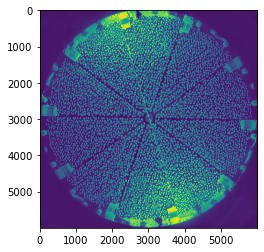

In [10]:
plt.imshow(denoised[0][0])

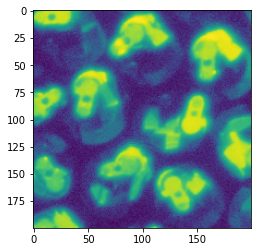

In [11]:
plt.imshow(denoised[0][0][1400:1600,1400:1600])

Text(0.5, 1.0, 'Numpy ')

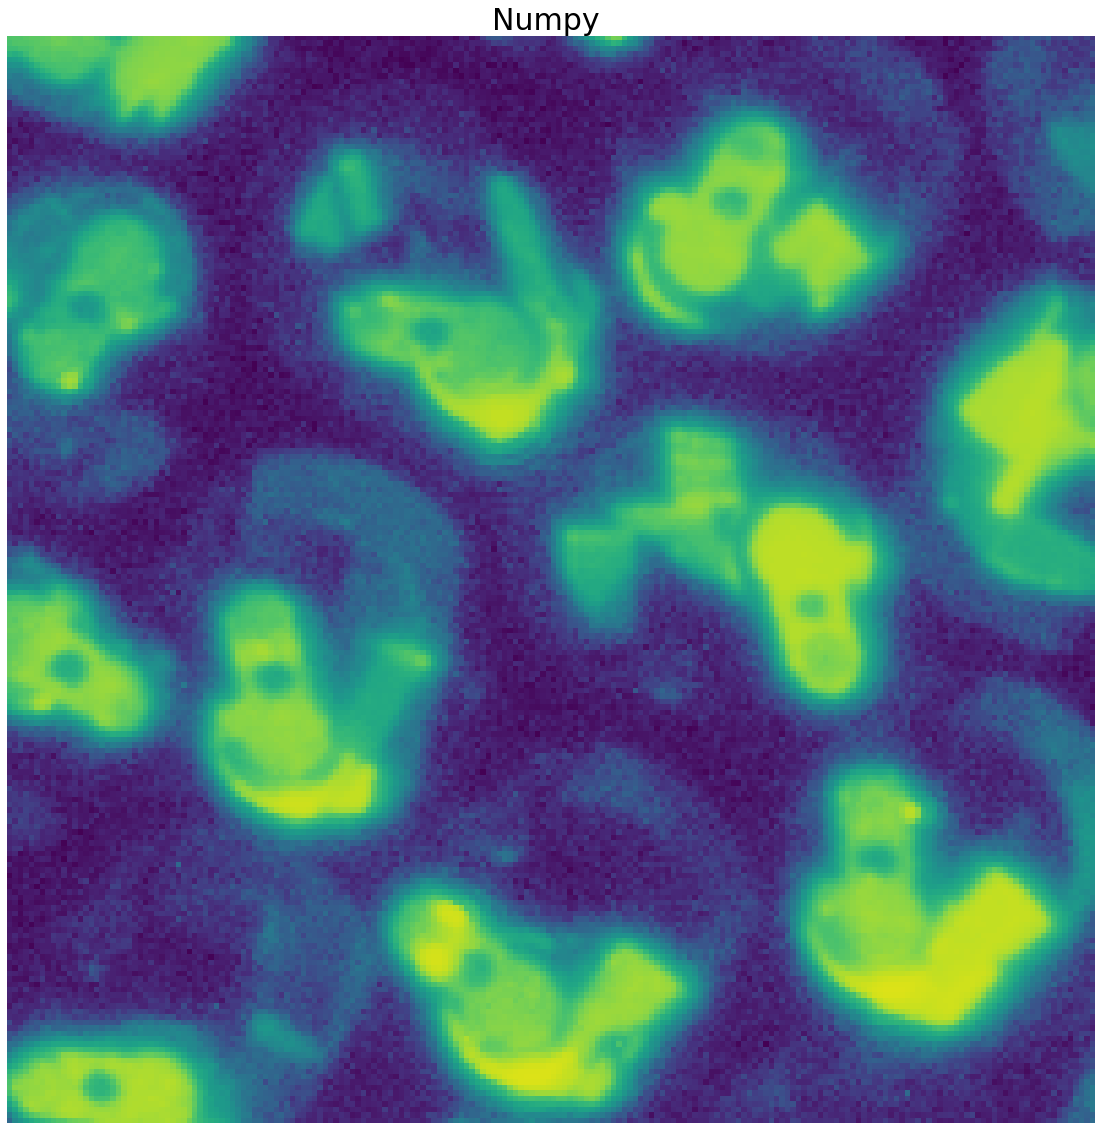

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(24,20))
vmin, vmax = np.percentile(denoised[0][0], (1,99))
# vmin, vmax = np.percentile(pytorch_output[sample][feature_map], (1,99))

ax.imshow(denoised[0][0][1400:1600, 1400:1600],vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
ax.axis('off')
ax.set_title('Numpy ', fontsize=30)


In [8]:
np.allclose(denoised[0][0], sample[0][0])

NameError: name 'denoised' is not defined

In [9]:
def model_flow(input_data, weights_dict, prefix_list):
    
    output = np_Conv2d(input_data=input_data,
                   weights_dict=weights_dict,
                   prefix=prefix_list[0])


    for i in range(len(prefix_list)-2):
        print(prefix_list[i+1])

        if prefix_list[i+1].endswith('0.'):

            output = np_Conv2d(input_data=output,
                               weights_dict=weights_dict,
                               prefix=prefix_list[i+1])

        elif layers_list[i+1].endswith('1.'):
            output = np_BatchNorm2d(input_data=output,
                                    weights_dict=weights_dict,
                                    prefix=prefix_list[i+1])

    output = np_Conv2d(input_data=output,
                       weights_dict=weights_dict,
                       prefix=prefix_list[-1])
    
    return output

%timeit output = model_flow(input_data=sample[:1], weights_dict=weights, prefix_list=layers_list)


layers.1.0.


KeyboardInterrupt: 

In [ ]:
# 1st layer
output = np_Conv2d(input_data=sample[:1],
                   weights_dict=weights,
                   prefix=layers_list[0])

[np_Conv2d(input_data=output,
           weights_dict=weights,
           prefix=layers_list[i+1])
 
if layers_list[i+1].endswith('0.') else
 
 np_BatchNorm2d(input_data=output,
                weights_dict=weights,
                prefix=layers_list[i+1])
 
for i in range(len(layers_list)-2)]

output = np_Conv2d(input_data=output, 
                   weights_dict=weights,
                   prefix=layers_lust[-1])

In [ ]:
plt.imshow(output[0][0])